In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ykucheri_0000158090
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [2]:
slice_name = "rtt-analysis-" + fablib.get_bastion_username()

try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
except:
    print("You don't have a slice named %s yet." % slice_name)
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!


In [137]:
node_conf = [
 {'name': "node-a",   'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "node-b",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}
]

net_conf = [
    {"name": "net0", "subnet": "10.10.1.0/24", "nodes": [{"name": "node-a",  "addr": "10.10.1.10"}]},
    {"name": "net1", "subnet": "10.10.2.0/24", "nodes": [{"name": "node-b",  "addr": "10.10.2.10"}]}
]

route_conf = [
    {"addr": "10.10.1.0/24", "gw": "10.10.2.10", "nodes": ["node-b"]},
    {"addr": "10.10.2.0/24", "gw": "10.10.1.10", "nodes": ["node-a"]}
]

In [138]:
exp_conf = {'cores': sum([n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf])}

site_name = "SEAT"
print("Selected site:", site_name)
fablib.show_site(site_name)


# Rest of the code for creating the slice remains the same

#ablib.show_site(site_name)

Selected site: SEAT


Name,SEAT
State,Active
Address,"2001 6th Ave,Seattle, WA 98121"
Location,"(47.614354750000004, -122.33886370511684)"
PTP Capable,False
Hosts,2
CPUs,4
Cores Available,64
Cores Capacity,256
Cores Allocated,192
RAM Available,488


'<pandas.io.formats.style.Styler object at 0x7f92007711b0>'

In [139]:
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [140]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

In [141]:
slice.submit()


Retry: 15, Time: 388 sec


ID,c6269054-b1d4-4711-a8da-3a3752e83e33
Name,rtt-analysis-ykucheri_0000158090
Lease Expiration (UTC),2024-04-23 01:15:10 +0000
Lease Start (UTC),2024-04-22 01:15:11 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
7197e43d-7492-44d8-a8f9-984a2f7b7eb7,node-a,2,4,10,default_ubuntu_20,qcow2,seat-w2.fabric-testbed.net,SEAT,ubuntu,2001:400:a100:3080:f816:3eff:fe4e:6f3a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe4e:6f3a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
393a6d6f-d1bc-48dd-9a70-be44829e9371,node-b,2,4,10,default_ubuntu_20,qcow2,seat-w2.fabric-testbed.net,SEAT,ubuntu,2001:400:a100:3080:f816:3eff:fe26:9ced,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe26:9ced,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
605c8aca-904d-40dd-93f1-bb9062f8ab49,net0,L2,L2Bridge,SEAT,None,None,Active,
2315912a-d110-49eb-af25-561a3521b91d,net1,L2,L2Bridge,SEAT,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
node-a-net0-p1,p1,node-a,net0,100,config,,1A:A5:2D:7F:EE:46,enp7s0,enp7s0,None,4
node-b-net1-p1,p1,node-b,net1,100,config,,1A:F2:B3:45:69:4C,enp7s0,enp7s0,None,4



Time to print interfaces 392 seconds


'c6269054-b1d4-4711-a8da-3a3752e83e33'

In [142]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

In [144]:
slice = fablib.get_slice(name=slice_name)

In [145]:
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [146]:
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [147]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.1.10 node-a
10.10.2.10 node-b
10.10.1.10 node-a
10.10.2.10 node-b


In [148]:
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [149]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [150]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

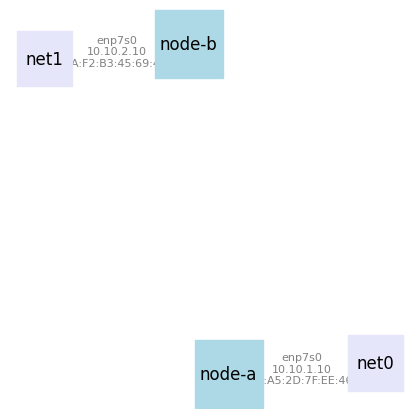

In [155]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [154]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
node-a,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe4e:6f3a
node-b,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe26:9ced


In [29]:
#first analysis
import pandas as pd

# Function to extract RTT values from ping results
def extract_rtt_from_ping_result(ping_result):
    rtt_str = ping_result.split('time=')[-1].split(' ')[0]
    return float(rtt_str)

# Function to read ping results from file and extract RTT values
def read_ping_results(file_path):
    with open(file_path, 'r') as file:
        ping_text_content = file.read()
    ping_lines = ping_text_content.strip().split('\n')
    rtt_values = [extract_rtt_from_ping_result(line) for line in ping_lines if 'time=' in line]
    return rtt_values

# Read ping results and extract RTT values for Node A
ping_results_node_a = read_ping_results('ping_results_nodea.txt')

# Read ping results and extract RTT values for Node B
ping_results_node_b = read_ping_results('ping_results_nodeb.txt')

# Create DataFrames for Node A and Node B
df_node_a = pd.DataFrame({'RTT (ms)': ping_results_node_a})
df_node_b = pd.DataFrame({'RTT (ms)': ping_results_node_b})

# Display the first few rows of each DataFrame
print("Node A RTT Data:")
print(df_node_a.head())
print("\nNode B RTT Data:")
print(df_node_b.head())


Node A RTT Data:
   RTT (ms)
0     0.272
1     0.260
2     0.308
3     0.235
4     0.199

Node B RTT Data:
   RTT (ms)
0     0.506
1     0.402
2     0.482
3     0.485
4     0.471


Node A RTT Statistics:
         RTT (ms)
count  460.000000
mean     0.227039
std      0.039076
min      0.165000
25%      0.202750
50%      0.219000
75%      0.244250
max      0.512000

Node B RTT Statistics:
         RTT (ms)
count  460.000000
mean     0.375046
std      0.072498
min      0.256000
25%      0.320000
50%      0.357000
75%      0.421250
max      0.697000


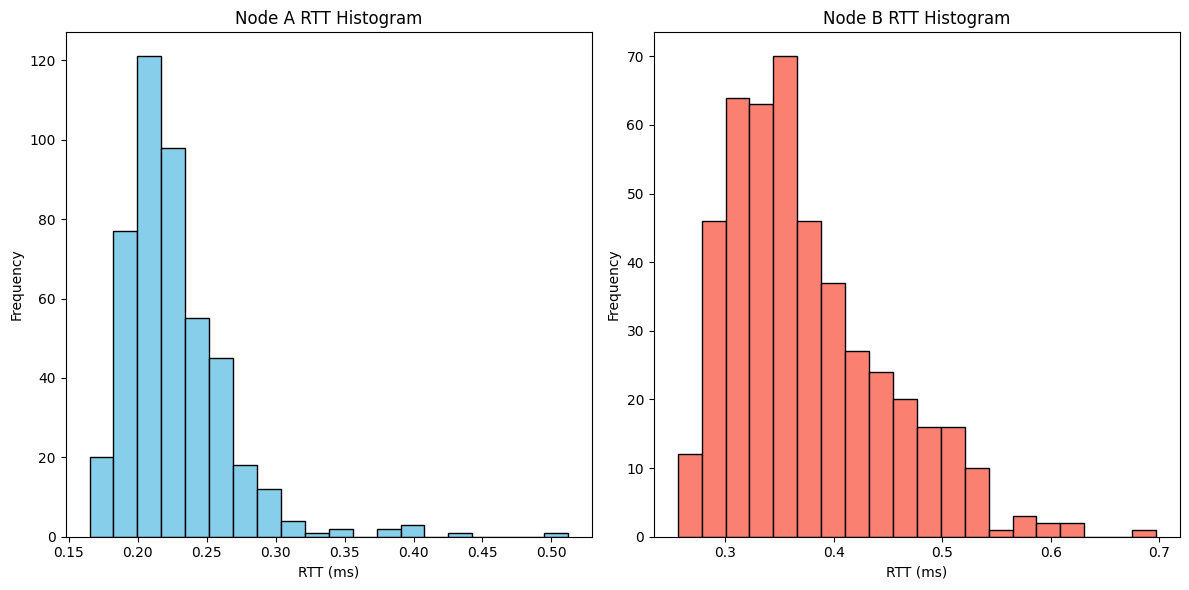

In [30]:
import matplotlib.pyplot as plt

# Statistical Analysis
node_a_stats = df_node_a.describe()
node_b_stats = df_node_b.describe()

print("Node A RTT Statistics:")
print(node_a_stats)
print("\nNode B RTT Statistics:")
print(node_b_stats)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_node_a['RTT (ms)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Node A RTT Histogram')
plt.xlabel('RTT (ms)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_node_b['RTT (ms)'], bins=20, color='salmon', edgecolor='black')
plt.title('Node B RTT Histogram')
plt.xlabel('RTT (ms)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


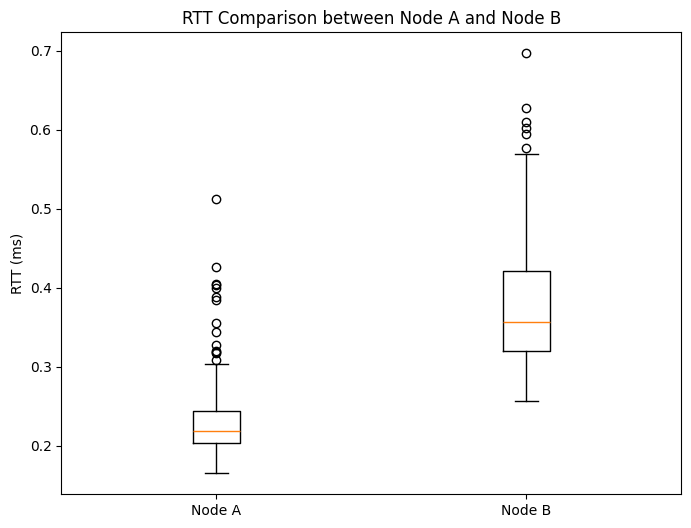

In [31]:
# Comparison
plt.figure(figsize=(8, 6))
plt.boxplot([df_node_a['RTT (ms)'], df_node_b['RTT (ms)']], labels=['Node A', 'Node B'])
plt.title('RTT Comparison between Node A and Node B')
plt.ylabel('RTT (ms)')
plt.show()
